In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import TensorDataset, DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Load and sort the training dataset by 'breath_id' and 'time_step'
df = pd.read_csv("data/train.csv")
df = df.sort_values(['breath_id', 'time_step'])

In [4]:
features = ['R', 'C', 'time_step', 'u_in', 'u_out']
# Group the data by breath_id to form sequences for LSTM input
grouped = df.groupby('breath_id')

In [5]:
###########################################
# Data Preparation: Grouping by Breath
###########################################

X_sequences = []
y_sequences = []
for breath_id, group in grouped:
    group = group.sort_values('time_step')
    X_sequences.append(group[features].values)
    y_sequences.append(group['pressure'].values)

# Convert lists to numpy arrays
X_sequences = np.array(X_sequences)  
y_sequences = np.array(y_sequences)
# Reshape targets to have an extra dimension for regression output
y_sequences = y_sequences.reshape(y_sequences.shape[0], y_sequences.shape[1], 1)

print("X_sequences shape:", X_sequences.shape)
print("y_sequences shape:", y_sequences.shape)

# Split into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

X_sequences shape: (75450, 80, 5)
y_sequences shape: (75450, 80, 1)


In [6]:
###########################################
# Create a PyTorch Dataset and DataLoader
###########################################

class BreathDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = BreathDataset(X_train_tensor, y_train_tensor)
val_dataset = BreathDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [7]:
###########################################
# Define the LSTM Model using PyTorch
###########################################

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=1, dropout=0.2):
        super(BiLSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size1 * 2, hidden_size2, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size2 * 2, output_size)
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = self.fc(out)
        return out

input_size = len(features)
model = BiLSTMModel(input_size=input_size).to(device)
print(model)

# loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

BiLSTMModel(
  (lstm1): LSTM(5, 64, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [9]:
###########################################
# Training Loop with Early Stopping
###########################################

num_epochs = 100
best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    avg_train_loss = np.mean(train_losses)
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())
    avg_val_loss = np.mean(val_losses)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break

# Load the best model state
model.load_state_dict(best_model_state)

Epoch 1/100, Train Loss: 1.4230, Val Loss: 0.7874
Epoch 2/100, Train Loss: 1.3838, Val Loss: 0.8075
Epoch 3/100, Train Loss: 1.3369, Val Loss: 0.6613
Epoch 4/100, Train Loss: 1.2873, Val Loss: 0.6353
Epoch 5/100, Train Loss: 1.2932, Val Loss: 0.6667
Epoch 6/100, Train Loss: 1.2239, Val Loss: 0.6421
Epoch 7/100, Train Loss: 1.2074, Val Loss: 0.6226
Epoch 8/100, Train Loss: 1.1656, Val Loss: 0.6052
Epoch 9/100, Train Loss: 1.1482, Val Loss: 0.5819
Epoch 10/100, Train Loss: 1.1255, Val Loss: 0.5893
Epoch 11/100, Train Loss: 1.1168, Val Loss: 0.5879
Epoch 12/100, Train Loss: 1.0857, Val Loss: 0.5977
Epoch 13/100, Train Loss: 1.0740, Val Loss: 0.5559
Epoch 14/100, Train Loss: 1.0639, Val Loss: 0.5859
Epoch 15/100, Train Loss: 1.0364, Val Loss: 0.5528
Epoch 16/100, Train Loss: 1.0272, Val Loss: 0.5566
Epoch 17/100, Train Loss: 1.0330, Val Loss: 0.5674
Epoch 18/100, Train Loss: 0.9906, Val Loss: 0.5875
Epoch 19/100, Train Loss: 0.9876, Val Loss: 0.6675
Epoch 20/100, Train Loss: 0.9724, Val Lo

<All keys matched successfully>

Validation MAE: 0.40171343
Validation MSE: 0.4074768
Validation RMSE: 0.6383391
Validation R2: 0.9937844276428223


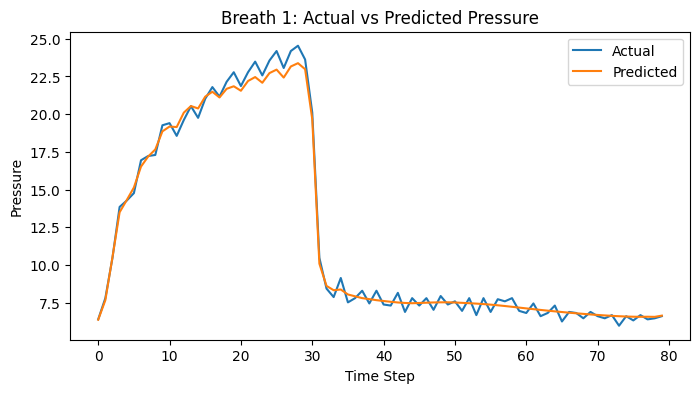

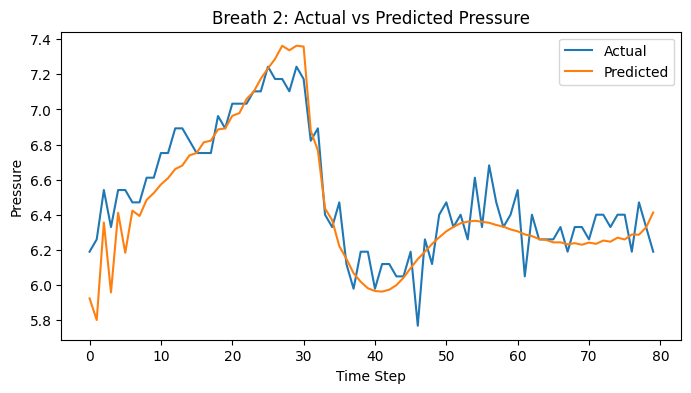

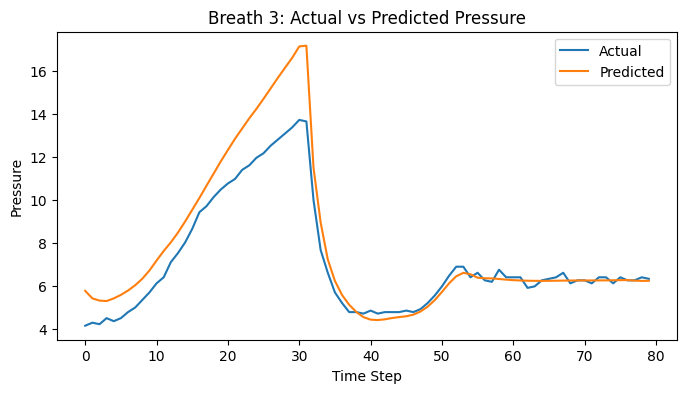

In [10]:
###########################################
# Evaluate on Validation Set & Visualization
###########################################

model.eval()
with torch.no_grad():
    y_val_pred_tensor = model(X_val_tensor)
y_val_pred = y_val_pred_tensor.cpu().numpy()
y_val_true = y_val_tensor.cpu().numpy()

y_val_true_flat = y_val_true.flatten()
y_val_pred_flat = y_val_pred.flatten()

# Calculate evaluation metrics
mae = mean_absolute_error(y_val_true_flat, y_val_pred_flat)
mse = mean_squared_error(y_val_true_flat, y_val_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_true_flat, y_val_pred_flat)

print("Validation MAE:", mae)
print("Validation MSE:", mse)
print("Validation RMSE:", rmse)
print("Validation R2:", r2)

# Plot Actual vs Predicted pressure for a few example breaths from the validation set
num_breaths_to_plot = 3
for i in range(num_breaths_to_plot):
    plt.figure(figsize=(8, 4))
    plt.plot(y_val[i].flatten(), label='Actual')
    plt.plot(y_val_pred[i].flatten(), label='Predicted')
    plt.title(f'Breath {i+1}: Actual vs Predicted Pressure')
    plt.xlabel('Time Step')
    plt.ylabel('Pressure')
    plt.legend()
    plt.show()

In [11]:
###########################################
# Generate Submission File from Test Data
###########################################

# Load and sort test dataset
df_test = pd.read_csv("data/test.csv")
df_test = df_test.sort_values(['breath_id', 'time_step'])
grouped_test = df_test.groupby('breath_id')

X_test_sequences = []
ids = []
for breath_id, group in grouped_test:
    group = group.sort_values('time_step')
    X_test_sequences.append(group[features].values)
    ids.extend(group['id'].values)

X_test_sequences = np.array(X_test_sequences)

X_test_tensor = torch.tensor(X_test_sequences, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

y_test_pred_list = []

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    for batch in test_loader:
        x_batch = batch[0].to(device)
        preds = model(x_batch)
        y_test_pred_list.append(preds.cpu().numpy())

# Concatenate predictions from all batches
y_test_pred_sequences = np.concatenate(y_test_pred_list, axis=0)
y_test_pred_flat = y_test_pred_sequences.flatten()

# Create submission DataFrame and save to CSV
submission_df = pd.DataFrame({'id': ids, 'pressure': y_test_pred_flat})
submission_df.to_csv("bi_lstm.csv", index=False)
print("Submission file created: bi_lstm.csv")

Submission file created: bi_lstm.csv
